In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

import os
if not os.path.isdir('figures'):
    os.makedirs('figures')

In [2]:
epochs = 1500
batch_size = 8
#num_neurons = 10
seed = 10

input_size=5 #optimal no. of features

beta = 1e-3
alpha = 1e-3

l2=keras.regularizers.l2(beta)
sgd=keras.optimizers.SGD(learning_rate=alpha)

histories={}

np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
#read and divide data into test and train sets 
admit_data = np.genfromtxt('admission_predict.csv', delimiter= ',')
X_data, Y_data = admit_data[1:,1:8], admit_data[1:,-1]
Y_data = Y_data.reshape(Y_data.shape[0], 1)

X_train, X_test, Y_train, Y_test = train_test_split(X_data,Y_data,test_size = 0.3, random_state = seed, shuffle=True)

#Preprocess by standardizing the Xtrain and Xtest based on Xtrain stats
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [4]:
#RFE
train_data_6_feature = []
test_data_6_feature = []

#Make train and test set for 6 features RFE.
for feature_idx in range(7):
    temp = np.delete(X_train,obj=feature_idx,axis=1)
    train_data_6_feature.append(temp)
    temp = np.delete(X_test,obj=feature_idx,axis=1)
    test_data_6_feature.append(temp)
    
#keep model with lowest m.s.e (model that removed feature 6 Research has lowest average test mse)
X6_train, X6_test = train_data_6_feature[6],test_data_6_feature[6]

train_data_5_feature = []
test_data_5_feature = []

#Make train and test set for 5 features RFE.
for feature_idx in range(6):
    temp = np.delete(X6_train,obj=feature_idx,axis=1)
    train_data_5_feature.append(temp)
    temp = np.delete(X6_test,obj=feature_idx,axis=1)
    test_data_5_feature.append(temp)
    
#Keep model with lowest MSE (from removing the feature 3 or SOP)
X5_train, X5_test = train_data_5_feature[3],test_data_5_feature[3]

In [5]:
# build_fn for sklearn wrapped
def get_3_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(10, input_dim = input_size, activation='relu',kernel_regularizer=l2))
    model.add(keras.layers.Dense(1))

    model.compile(optimizer=sgd,
                  loss=keras.losses.MeanSquaredError(),
                  metrics=['mse'])
    
    return model

def get_4_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(50, input_dim = input_size, activation='relu',kernel_regularizer=l2))
    model.add(keras.layers.Dense(50, activation='relu',kernel_regularizer=l2))
    model.add(keras.layers.Dense(1))

    model.compile(optimizer=sgd,
                  loss=keras.losses.MeanSquaredError(),
                  metrics=['mse'])
    
    return model

#Add drop out for both visible and hidden layers
def get_4_dropout_model():
    model = keras.Sequential()
    model.add(keras.layers.Dropout(0.2, input_shape=(5,)))
    model.add(keras.layers.Dense(50, activation='relu',kernel_regularizer=l2))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(50, activation='relu',kernel_regularizer=l2))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1))
    
    model.compile(optimizer=sgd,
              loss=keras.losses.MeanSquaredError(),
              metrics=['mse'])
    
    return model
    
def get_5_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(50, input_dim = input_size, activation='relu',kernel_regularizer=l2))
    model.add(keras.layers.Dense(50, activation='relu',kernel_regularizer=l2))
    model.add(keras.layers.Dense(50, activation='relu',kernel_regularizer=l2))
    model.add(keras.layers.Dense(1))

    model.compile(optimizer=sgd,
                  loss=keras.losses.MeanSquaredError(),
                  metrics=['mse'])
    
    return model

#Add drop out for both visible and hidden layers
def get_5_dropout_model():
    model = keras.Sequential()
    model.add(keras.layers.Dropout(0.2, input_shape=(5,)))
    model.add(keras.layers.Dense(50, activation='relu',kernel_regularizer=l2))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(50, activation='relu',kernel_regularizer=l2))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(50, activation='relu',kernel_regularizer=l2))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1))
    
    model.compile(optimizer=sgd,
              loss=keras.losses.MeanSquaredError(),
              metrics=['mse'])
    
    return model


In [6]:
mse_all=[]
for i in range(5):
    print("Experiments %s"%i)

    #3 layer, 5 features
    model_3 = get_3_model()
    results_3 = model_3.fit(X5_train,Y_train, validation_data = (X5_test, Y_test),
                       epochs=epochs, batch_size=batch_size, verbose=0)
    best_3_mse = min(results_3.history['val_mse'])
    print("min mse for optimal 3 layers network: %.5f"%best_3_mse)
    
    #4 layer, 5 features
    model_4 = get_4_model()
    results_4 = model_4.fit(X5_train,Y_train, validation_data = (X5_test, Y_test),
                       epochs=epochs, batch_size=batch_size, verbose=0)
    best_4_mse = min(results_4.history['val_mse'])
    print("min mse for 4 layers network: %.5f"%best_4_mse)
    
    #4 layer, drop out, 5 features
    model_4_dropout = get_4_dropout_model()
    results_4_dropout = model_4_dropout.fit(X5_train,Y_train, validation_data = (X5_test, Y_test),
                       epochs=epochs, batch_size=batch_size, verbose=0)
    best_4drop_mse = min(results_4_dropout.history['val_mse'])
    print("min mse for 4 layers + dropout network: %.5f"%best_4drop_mse)
    
    #5 layer, 5 features
    model_5 = get_5_model()
    results_5 = model_5.fit(X5_train,Y_train, validation_data = (X5_test, Y_test),
                       epochs=epochs, batch_size=batch_size, verbose=0)
    best_5_mse = min(results_5.history['val_mse'])
    print("min mse for 5 layers network: %.5f"%best_5_mse)
    
    #5 layer, drop out, 5 features
    model_5_dropout = get_5_dropout_model()
    results_5_dropout = model_5_dropout.fit(X5_train,Y_train, validation_data = (X5_test, Y_test),
                       epochs=epochs, batch_size=batch_size, verbose=0)
    best_5drop_mse = min(results_5_dropout.history['val_mse'])
    print("min mse for 5 layers + dropout network: %.5f"%best_5drop_mse)
    
    mse_all.append([best_3_mse,best_4_mse,best_4drop_mse,best_5_mse,best_5drop_mse])

Experiments 0
min mse for optimal 3 layers network: 0.00759
min mse for 4 layers network: 0.00582
min mse for 4 layers + dropout network: 0.00611
min mse for 5 layers network: 0.00559
min mse for 5 layers + dropout network: 0.00705
Experiments 1
min mse for optimal 3 layers network: 0.00572
min mse for 4 layers network: 0.00557
min mse for 4 layers + dropout network: 0.00629
min mse for 5 layers network: 0.00554
min mse for 5 layers + dropout network: 0.00624
Experiments 2
min mse for optimal 3 layers network: 0.00619
min mse for 4 layers network: 0.00576
min mse for 4 layers + dropout network: 0.00622
min mse for 5 layers network: 0.00531
min mse for 5 layers + dropout network: 0.00655
Experiments 3
min mse for optimal 3 layers network: 0.00740
min mse for 4 layers network: 0.00586
min mse for 4 layers + dropout network: 0.00603
min mse for 5 layers network: 0.00625
min mse for 5 layers + dropout network: 0.00666
Experiments 4
min mse for optimal 3 layers network: 0.00643
min mse for 

In [7]:
print(mse_all)
mse_ave = np.array(mse_all).mean(axis=0)
print(mse_ave)

[[0.0075913770124316216, 0.005821620114147663, 0.0061057391576468945, 0.005585022736340761, 0.007049760781228542], [0.005719524808228016, 0.0055735413916409016, 0.006294944789260626, 0.005544648971408606, 0.006240874528884888], [0.006189498584717512, 0.005763488821685314, 0.0062233018688857555, 0.005306670907884836, 0.006550791207700968], [0.0074028256349265575, 0.00585633609443903, 0.006028148345649242, 0.006254430394619703, 0.006655985489487648], [0.006432958412915468, 0.006202508229762316, 0.0058078826405107975, 0.00584911135956645, 0.006644917652010918]]
[0.00666724 0.0058435  0.006092   0.00570798 0.00662847]


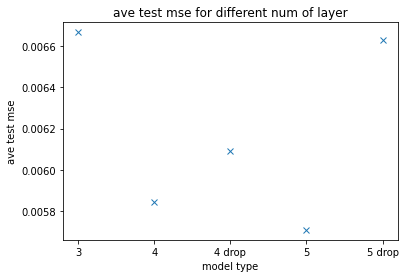

In [8]:
plt.plot(['3','4','4 drop','5','5 drop'],mse_ave,linestyle='None',marker='x')
plt.ylabel('ave test mse')
plt.xlabel('model type')
plt.title('ave test mse for different num of layer')
plt.savefig('./figures/3B_ave_5_experiments_test_mse.png')